# Import Packages

In [1]:
# import packages

# general tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import warnings
import json 


# RDKit
from rdkit import Chem, RDLogger

# scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# set global options

RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")

In [3]:
# import functions written for this project
from modules import *

In [4]:
# import and check funtionality of pytorch / pytorch geometric

import torch
import torch_geometric

print("Pytorch version = ", torch.__version__)
print("Pytorch Geometric version = ", torch_geometric.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.10.2+cu113
Pytorch Geometric version =  2.0.3
CUDA version =  11.3
CUDA available =  False
Random Pytorch test tensor =  tensor([0.0609])


# Load and Prepare Data

In [5]:
# create dictionary to collect experimental settings
settings_dict = {}

In [6]:
# choose ChEMBL dopamine D2 data set

datafolder_filepath = "data/chembl_dopamine_d2/"
settings_dict["target_name"] = "chembl_dopamine_d2"
activity_type = "Ki [nM]"

In [7]:
# or choose ChEMBL factor Xa data set

datafolder_filepath = "data/chembl_factor_xa/"
settings_dict["target_name"] = "chembl_factor_xa"
activity_type = "Ki [nM]"

In [8]:
# or choose PostEra SARS-CoV 2 Mpro data set

datafolder_filepath = "data/postera_sars_cov_2_mpro/"
settings_dict["target_name"] = "postera_sars_cov_2_mpro"
activity_type = "f_avg_IC50 [uM]"

In [9]:
# load clean data
#display data from postera_sars_cov_2_mpro

dataframe = pd.read_csv(datafolder_filepath + "molecule_data_clean.csv", sep = ",")
settings_dict["n_molecules"] = len(dataframe)
display(dataframe)

,SMILES,f_avg_IC50 [uM]
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,0.275118
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,0.202767
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,55.453947
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,0.050000
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,0.052757
...,...,...
1919,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,99.010000
1920,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,54.272964
1921,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,63.554925
1922,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,26.719515


Shape of x_smiles =  (1924,)
CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc2S1(=O)=O


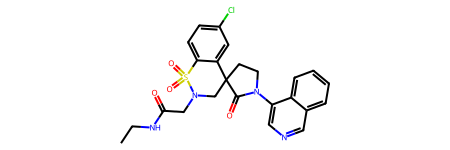

In [10]:
# construct array with SMILES strings

x_smiles = dataframe["SMILES"].values

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

Mean value (y) =  -0.9180193183732708
Standard deviation (y) =  1.04434733236911
Maximum value (y) =  2.573819647563703
Minimum value (y) =  -2.296665190261531
Shape (y) =  (1924,)


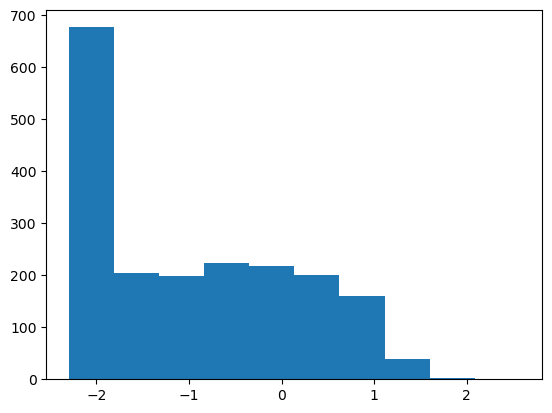

In [11]:
# construct array with activity labels y (via applying the negative decadic logarithm to the experimental activity measurements)

y = -np.log10(dataframe[activity_type].values.astype(float))

print("Mean value (y) = ", np.mean(y))
print("Standard deviation (y) = ", np.std(y))
print("Maximum value (y) = ", np.amax(y))
print("Minimum value (y) = ", np.amin(y))
print("Shape (y) = ", y.shape)
plt.hist(y)
plt.show()

In [12]:
# create dictionary which maps SMILES strings to their activity labels

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))
# print(x_smiles_to_y_dict)

In [13]:
# import matched molecular pair (MMP) dataframe

dataframe_mmps = pd.read_csv(datafolder_filepath + "MMP_data_clean.csv",
                             sep = ",",
                             header = 0)

print("Number of matched molecular pairs (MMPs) = ", len(dataframe_mmps))
display(dataframe_mmps.head(n = 3))

Number of matched molecular pairs (MMPs) =  12594


,smiles_1,smiles_2,transformation,constant_part
0,COc1cc(Br)ccc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,COc1ncc(Br)cc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,[*:1]c1ccc([*:2])c([*:3])c1>>[*:1]c1cnc([*:3])...,[*:1]Br.[*:2]Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23...
1,O=C(Cc1cc(Cl)cc(NCc2ccc(Br)cc2)c1)Nc1cncc2ccccc12,COc1cc(Br)ccc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,[*:1]NCc1ccc([*:2])cc1>>[*:1]Nc1ccc([*:2])cc1OC,[*:2]Br.[*:1]c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1
2,O=C(Cc1cc(Cl)cc(NCc2ccc(Br)cc2)c1)Nc1cncc2ccccc12,COc1ncc(Br)cc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,[*:1]NCc1ccc([*:2])cc1>>[*:1]Nc1cc([*:2])cnc1OC,[*:2]Br.[*:1]c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1


In [14]:
# construct MMP array and binary MMP labels for AC-prediction (we delete half-cliffs)

# create array with all MMPs (including half-cliffs)
X_smiles_mmps = dataframe_mmps.values[:,0:2]

# create array with all MMP cores
x_smiles_mmp_cores = dataframe_mmps.values[:,3]

# label ACs with 1 and other MMPs (= half-cliffs and non-ACs) with 0
y_mmps = np.array([int(abs(x_smiles_to_y_dict[smiles_1] - x_smiles_to_y_dict[smiles_2]) >= 2) 
                   for [smiles_1, smiles_2] in X_smiles_mmps])

# determine indices for MMPs which are half-cliffs (these should be deleted)
y_mmps_half_cliffs = np.array([int(1 < abs(x_smiles_to_y_dict[smiles_1] - x_smiles_to_y_dict[smiles_2]) < 2) 
                               for [smiles_1, smiles_2] in X_smiles_mmps])
ind_delete = np.ndarray.flatten(np.argwhere(y_mmps_half_cliffs > 0))

# delete MMPs which are half-cliffs
X_smiles_mmps = np.delete(X_smiles_mmps, ind_delete, axis = 0)
settings_dict["n_mmps"] = len(X_smiles_mmps)
x_smiles_mmp_cores = np.delete(x_smiles_mmp_cores, ind_delete, axis = 0)
y_mmps = np.delete(y_mmps, ind_delete)

print("Shape of X_smiles_mmps = ", X_smiles_mmps.shape)
print("Shape of x_smiles_mmp_cores = ", x_smiles_mmp_cores.shape)
print("Number of distinct cores = ", len(set(x_smiles_mmp_cores)), "\n")
print("Shape of y_mmps = ", y_mmps.shape)
print("Number of molecules = ", settings_dict["n_molecules"])
print("Number of MMPs = non-ACs + half-cliffs + ACs = ", len(dataframe_mmps))
print("Number of non-ACs with activity difference less than 1 order of magnitude = ", np.sum(1 - y_mmps))
print("Number of deleted half-cliffs with activity difference between 1 and 2 orders of magnitude = ", len(ind_delete))
print("Number of ACs with property difference larger than 2 orders of magnitude = ", np.sum(y_mmps))
print("Ratio of non-ACs to ACs = ", np.round(np.sum(1 - y_mmps)/np.sum(y_mmps), 3), ": 1")

Shape of X_smiles_mmps =  (10832, 2)
Shape of x_smiles_mmp_cores =  (10832,)
Number of distinct cores =  741 

Shape of y_mmps =  (10832,)
Number of molecules =  1924
Number of MMPs = non-ACs + half-cliffs + ACs =  12594
Number of non-ACs with activity difference less than 1 order of magnitude =  10311
Number of deleted half-cliffs with activity difference between 1 and 2 orders of magnitude =  1762
Number of ACs with property difference larger than 2 orders of magnitude =  521
Ratio of non-ACs to ACs =  19.791 : 1


In [15]:
# construct array with activity values for mmps

Y_mmps_vals = np.array([[x_smiles_to_y_dict[smiles_1], x_smiles_to_y_dict[smiles_2]] for [smiles_1, smiles_2] in X_smiles_mmps])
print("Shape of Y_mmps_vals = ", Y_mmps_vals.shape)


Shape of Y_mmps_vals =  (10832, 2)


In [16]:
# randomly flip or maintain direction of all smiles pairs in X_smiles_mmps and Y_mmps_vals to make potency directionality classification balanced

np.random.seed(42)

for k in range(len(X_smiles_mmps)):
    if np.random.uniform(0,1) > 0.5:
        
        X_smiles_mmps[k, 0:2] = np.flip(X_smiles_mmps[k, 0:2])
        Y_mmps_vals[k, 0:2] = np.flip(Y_mmps_vals[k, 0:2])    

In [17]:
# construct potency directionality target variable (0: smiles_1 activity is larger than or equal to smiles_2 activity, 1: smiles_1 activity is smaller than smiles_2 activity)

y_mmps_pd = np.array([int(val_1 < val_2) for [val_1, val_2] in Y_mmps_vals])

print("Shape of y_mmps_pd = ", y_mmps_pd.shape)
print("Number of 1s = ", np.sum(y_mmps_pd))

Shape of y_mmps_pd =  (10832,)
Number of 1s =  4704


# Prepare Data Split for Individual Compounds and MMPs

In [18]:
# create data split dictionary for k-fold cross validation repeated with m random seeds

settings_dict["k_splits"] = 2
settings_dict["m_reps"] = 3
settings_dict["random_state_cv"] = 42

data_split_dictionary = create_data_split_dictionary_for_mols_and_mmps(x_smiles,
                                                                       X_smiles_mmps,
                                                                       x_smiles_mmp_cores,
                                                                       k_splits = settings_dict["k_splits"],
                                                                       m_reps = settings_dict["m_reps"],
                                                                       random_state_cv = settings_dict["random_state_cv"])

In [19]:
# inspect high-level contents of data split dictionary

inspect_data_split_dictionary(data_split_dictionary, y_mmps);

,m,k,D_train,D_test,M_train_pos,M_train_neg,M_inter_pos,M_inter_neg,M_test_pos,M_test_neg,M_cores_pos,M_cores_neg
*,0,0,962,962,72,2383,270,5143,179,2785,10,163
*,0,1,962,962,179,2785,270,5143,72,2383,14,137
*,1,0,962,962,140,2772,270,5209,111,2330,5,190
*,1,1,962,962,111,2330,270,5209,140,2772,3,170
*,2,0,962,962,153,2618,258,5095,110,2598,11,195
*,2,1,962,962,110,2598,258,5095,153,2618,11,198
Avg,*,*,962.0,962.0,127.5,2581.0,266.0,5149.0,127.5,2581.0,9.0,175.5


# Generate Molecular Representations

## ECFPs

In [20]:
# #save/load x_smiles_to_fp_dict to txt file
# import json 
# with open('x_smiles_to_fp_dict.txt', 'w') as file:
#      file.write(json.dumps(x_smiles_to_fp_dict))

In [21]:
# set ECFP hyperparameters
settings_dict["radius"] = 2
settings_dict["bitstring_length"] = 2**11
settings_dict["use_features"] = False
settings_dict["use_chirality"] = True

# create dictionary that maps SMILES strings to ECFPs
x_fp = {}

for smiles in x_smiles:

    x_fp.update({smiles : circular_fps_from_smiles(smiles,
                                         radius = settings_dict["radius"],
                                         bitstring_length = settings_dict["bitstring_length"],
                                         use_features = settings_dict["use_features"],
                                         use_chirality = settings_dict["use_chirality"]).tolist()})
with open('smiles_fp_dict.txt', 'w') as file:
    file.write(json.dumps(x_fp))

x_smiles_to_fp_dict = x_fp
# dict(list(zip(x_smiles, x_fp)))

In [22]:
# # set ECFP hyperparameters
# settings_dict["radius"] = 2
# settings_dict["bitstring_length"] = 2**11
# settings_dict["use_features"] = False
# settings_dict["use_chirality"] = True

# create dictionary that maps SMILES strings to ECFPs
x_3fp = {}

for smiles in x_smiles:

    x_3fp.update({smiles: e3fp_from_smiles(smiles).tolist()})
with open('smiles_3fp_dict.txt', 'w') as file:
    file.write(json.dumps(x_3fp))

# x_smiles_to_3fp_dict = dict(list(zip(x_smiles, x_3fp)))

2023-04-04 14:55:09,516|INFO|Generating conformers for placeholder_name.
2023-04-04 14:55:16,444|INFO|Generated 1 conformers for placeholder_name.
2023-04-04 14:55:16,448|INFO|Generating fingerprints for placeholder_name.
2023-04-04 14:55:16,652|INFO|Generated 1 fingerprints for placeholder_name.
2023-04-04 14:55:16,658|INFO|Generating conformers for placeholder_name.
2023-04-04 14:55:23,065|INFO|Generated 1 conformers for placeholder_name.
2023-04-04 14:55:23,069|INFO|Generating fingerprints for placeholder_name.
2023-04-04 14:55:23,260|INFO|Generated 1 fingerprints for placeholder_name.
2023-04-04 14:55:23,265|INFO|Generating conformers for placeholder_name.
2023-04-04 14:55:31,215|INFO|Generated 1 conformers for placeholder_name.
2023-04-04 14:55:31,218|INFO|Generating fingerprints for placeholder_name.
2023-04-04 14:55:31,401|INFO|Generated 1 fingerprints for placeholder_name.
2023-04-04 14:55:31,407|INFO|Generating conformers for placeholder_name.
2023-04-04 14:55:39,176|INFO|Gene

NameError: name 'x_smiles_to_3fp_dict' is not defined

## PDVs

In [ ]:
# create PDVs
settings_dict["descriptor_list"] = None # use default 200 descriptors from literature

X_pdv = list(range(settings_dict["n_molecules"]))
for (k, smiles) in enumerate(x_smiles):
    X_pdv[k] = rdkit_mol_descriptors_from_smiles(smiles, descriptor_list = settings_dict["descriptor_list"])
X_pdv = np.array(X_pdv)

# replace NaN with 0
print("Number of NaN values to replace = ", np.sum(np.isnan(X_pdv)),"(",100*np.sum(np.isnan(X_pdv))/(X_pdv.shape[0]*X_pdv.shape[1]) ,r"%)")
X_pdv = np.nan_to_num(X_pdv)
print("Shape of X_pdv = ", X_pdv.shape)

# create dictionary that maps SMILES strings to PDVs
x_smiles_to_pdv_dict = dict(list(zip(x_smiles, X_pdv)))

Number of NaN values to replace =  0 ( 0.0 %)
Shape of X_pdv =  (1924, 200)


## Molecular Graphs

In [ ]:
len(list(x_smiles_to_pdv_dict.values())[0])

200

In [ ]:
# create molecular graphs as list of geometric data objects

graph_list = create_pytorch_geometric_data_set_from_smiles_and_targets(x_smiles, y)

# Experimentally Evaluate QSAR Models

## ECFP + RF

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "ecfp_rf"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_estimators": [500], 
                                        "max_depth": [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None],
                                        "min_samples_split": [2, 4, 6, 8, 10, 12],
                                        "min_samples_leaf": [1, 2, 3, 4, 5, 6],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "bootstrap": [True, False],
                                        "random_state": [42]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (for individual molecules)        
    X_fp_train = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_train_mols]])
    y_train = y[ind_train_mols]
    
    X_fp_test = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_test_mols]])
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])
    
    # fit the model on the training data
    regressor.fit(X_fp_train, y_train)
    
    # create and store qsar, ac, and pd-predictions
    y_pred = regressor.predict(np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles]))
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## ECFP + kNN

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "ecfp_knn"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_neighbors": list(range(1, 101)),
                                        "weights": ["uniform", "distance"],
                                        "p": [1, 2, 3]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_fp_train = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_train_mols]])
    y_train = y[ind_train_mols]
    
    X_fp_test = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_test_mols]])
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = KNeighborsRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_fp_train, y_train)
    
    # create and store qsar, ac, and pd-predictions
    y_pred = regressor.predict(np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles]))
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## ECFP + MLP

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "ecfp_mlp"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# hyperparameter- and optuna options

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(settings_dict["bitstring_length"], 1, w, d) for (w,d) in all_combs_list([64, 128, 256, 512], [1, 5, 10])],
                                          "hidden_activation": [nn.ReLU()],
                                          "output_activation": [nn.Identity()],
                                          "use_bias": [True],
                                          "hidden_dropout_rate": [0, 0.25],
                                          "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128],
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)
    X_fp = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles])
    
    X_fp_train = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_train_mols]])
    y_train = y[ind_train_mols]
    Y_train = np.reshape(y_train, (-1, 1))
    
    X_fp_test = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_test_mols]])
    y_test = y[ind_test_mols]
    Y_test = np.reshape(y_test, (-1, 1))
    
    # create pytorch dataset objects for training and testing
    dataset_train = TensorDataset(torch.tensor(X_fp_train, dtype = torch.float), torch.tensor(Y_train, dtype = torch.float))
    dataset_test = TensorDataset(torch.tensor(X_fp_test, dtype = torch.float), torch.tensor(Y_test, dtype = torch.float))
    
    # find best hyperparameters via optuna and train associated model on training set
    (regressor, 
     loss_curve_training_set) = train_mlps_via_optuna(dataset_train,
                                                      settings_dict["optuna_options"],
                                                      settings_dict["mlp_hyperparameter_grid"], 
                                                      settings_dict["train_hyperparameter_grid"])
    
    # plot learning curves
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor(torch.tensor(X_fp, dtype = torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()[:,0]
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## PDV + RF

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "pdv_rf"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_estimators": [500], 
                                        "max_depth": [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None],
                                        "min_samples_split": [2, 4, 6, 8, 10, 12],
                                        "min_samples_leaf": [1, 2, 3, 4, 5, 6],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "bootstrap": [True, False],
                                        "random_state": [42]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_pdv_train = X_pdv[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_pdv_test = X_pdv[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # normalise data with empirical cumulative distribution functions for each feature (ecdf derived from training set)
    (X_pdv_norm_train, normalisation_function) = normaliser_cdf(X_pdv_train)
    X_pdv_norm_test = normalisation_function(X_pdv_test)
    X_pdv_norm = normalisation_function(X_pdv)
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_pdv_norm_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_pdv_norm)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## PDV + kNN

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "pdv_knn"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_neighbors": list(range(1, 101)),
                                        "weights": ["uniform", "distance"],
                                        "p": [1, 2, 3]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_pdv_train = X_pdv[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_pdv_test = X_pdv[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # normalise data with empirical cumulative distribution functions for each feature (ecdf derived from training set)
    (X_pdv_norm_train, normalisation_function) = normaliser_cdf(X_pdv_train)
    X_pdv_norm_test = normalisation_function(X_pdv_test)
    X_pdv_norm = normalisation_function(X_pdv)
    
     # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = KNeighborsRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_pdv_norm_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_pdv_norm)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## PDV + MLP

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "pdv_mlp"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# hyperparameter- and optuna options

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(200, 1, w, d) for (w,d) in all_combs_list([64, 128, 256, 512], [1, 5, 10])],
                                          "hidden_activation": [nn.ReLU()],
                                          "output_activation": [nn.Identity()],
                                          "use_bias": [True],
                                          "hidden_dropout_rate": [0, 0.25],
                                          "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128],
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_pdv_train = X_pdv[ind_train_mols]
    y_train = y[ind_train_mols]
    Y_train = np.reshape(y_train, (-1, 1))
    
    X_pdv_test = X_pdv[ind_test_mols]
    y_test = y[ind_test_mols]
    Y_test = np.reshape(y_test, (-1, 1))
    
    # normalise data with empirical cumulative distribution functions for each feature (ecdf derived from training set)
    (X_pdv_norm_train, normalisation_function) = normaliser_cdf(X_pdv_train)
    X_pdv_norm_test = normalisation_function(X_pdv_test)
    X_pdv_norm = normalisation_function(X_pdv)
    
    # create pytorch dataset objects for training and testing
    dataset_train = TensorDataset(torch.tensor(X_pdv_norm_train, dtype = torch.float), torch.tensor(Y_train, dtype = torch.float))
    dataset_test = TensorDataset(torch.tensor(X_pdv_norm_test, dtype = torch.float), torch.tensor(Y_test, dtype = torch.float))
    
    # find best hyperparameters via optuna and train associated model on training set
    (regressor, 
     loss_curve_training_set) = train_mlps_via_optuna(dataset_train,
                                                      settings_dict["optuna_options"],
                                                      settings_dict["mlp_hyperparameter_grid"], 
                                                      settings_dict["train_hyperparameter_grid"])
    # plot learning curves
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor(torch.tensor(X_pdv_norm, dtype = torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()[:,0]
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## GIN + RF

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "gin_rf"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# GNN + MLP: hyperparameter- and optuna settings

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["gin_hyperparameter_grid"] = {"n_conv_layers": [1, 2, 3],
                                            "input_dim": [79],
                                            "hidden_dim": [64, 128, 256],
                                            "mlp_n_hidden_layers": [2],
                                            "mlp_hidden_activation": [nn.ReLU()],
                                            "mlp_output_activation": [nn.Identity()],
                                            "mlp_use_bias": [True],
                                            "mlp_hidden_dropout_rate": [0, 0.25],
                                            "mlp_hidden_batchnorm": [True],
                                            "eps": [0],
                                            "train_eps": [False],
                                            "pooling_operation": [global_max_pool]}

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(None, 1, w, d) for (w,d) in all_combs_list([None], [0])],
                                            "hidden_activation": [nn.ReLU()],
                                            "output_activation": [nn.Identity()],
                                            "use_bias": [True],
                                            "hidden_dropout_rate": [0],
                                            "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128], 
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [ ]:
# RF: hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_estimators": [500], 
                                        "max_depth": [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None],
                                        "min_samples_split": [2, 4, 6, 8, 10, 12],
                                        "min_samples_leaf": [1, 2, 3, 4, 5, 6],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "bootstrap": [True, False],
                                        "random_state": [42]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (GNN + MLP)
    graph_list_train = [graph_list[k] for k in ind_train_mols]
    graph_list_test = [graph_list[k] for k in ind_test_mols]
    
    # find best hyperparameters via optuna and train associated model on training set (GNN + MLP)
    (trained_best_gnn_model, 
     trained_best_mlp_model, 
     loss_curve_training_set) = train_gnn_mlps_via_optuna(graph_list_train,
                                                          settings_dict["optuna_options"],
                                                          settings_dict["gin_hyperparameter_grid"], 
                                                          settings_dict["mlp_hyperparameter_grid"], 
                                                          settings_dict["train_hyperparameter_grid"])
    # plot learning curves (GNN + MLP)
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # extract learned features from molecular graphs via GNN
    dataloader = GeometricDataLoader(dataset = graph_list, batch_size = len(graph_list), shuffle = False, drop_last = False)
    trained_best_gnn_model.eval()
    for batch in dataloader:
        X_gnn = trained_best_gnn_model(batch.to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()
           
    # generate training- and test data       
    X_gnn_train = X_gnn[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_gnn_test = X_gnn[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_gnn_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_gnn)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## GIN + kNN

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "gin_knn"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# GNN + MLP: hyperparameter- and optuna settings

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["gin_hyperparameter_grid"] = {"n_conv_layers": [1, 2, 3],
                                            "input_dim": [79],
                                            "hidden_dim": [64, 128, 256],
                                            "mlp_n_hidden_layers": [2],
                                            "mlp_hidden_activation": [nn.ReLU()],
                                            "mlp_output_activation": [nn.Identity()],
                                            "mlp_use_bias": [True],
                                            "mlp_hidden_dropout_rate": [0, 0.25],
                                            "mlp_hidden_batchnorm": [True],
                                            "eps": [0],
                                            "train_eps": [False],
                                            "pooling_operation": [global_max_pool]}

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(None, 1, w, d) for (w,d) in all_combs_list([None], [0])],
                                            "hidden_activation": [nn.ReLU()],
                                            "output_activation": [nn.Identity()],
                                            "use_bias": [True],
                                            "hidden_dropout_rate": [0],
                                            "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128], 
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [ ]:
# kNN: hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_neighbors": list(range(1, 101)),
                                        "weights": ["uniform", "distance"],
                                        "p": [1, 2, 3]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (GNN + MLP)
    graph_list_train = [graph_list[k] for k in ind_train_mols]
    graph_list_test = [graph_list[k] for k in ind_test_mols]
    
    # find best hyperparameters via optuna and train associated model on training set (GNN + MLP)
    (trained_best_gnn_model, 
     trained_best_mlp_model, 
     loss_curve_training_set) = train_gnn_mlps_via_optuna(graph_list_train,
                                                          settings_dict["optuna_options"],
                                                          settings_dict["gin_hyperparameter_grid"], 
                                                          settings_dict["mlp_hyperparameter_grid"], 
                                                          settings_dict["train_hyperparameter_grid"])
    # plot learning curves (GNN + MLP)
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # extract learned features from molecular graphs via GNN
    dataloader = GeometricDataLoader(dataset = graph_list, batch_size = len(graph_list), shuffle = False, drop_last = False)
    trained_best_gnn_model.eval()
    for batch in dataloader:
        X_gnn = trained_best_gnn_model(batch.to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()
           
    # generate training- and test data       
    X_gnn_train = X_gnn[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_gnn_test = X_gnn[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = KNeighborsRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_gnn_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_gnn)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

## GIN + MLP

In [ ]:
# set directory for saving of experimental results

settings_dict["method_name"] = "gin_mlp"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# GNN + MLP: hyperparameter- and optuna settings

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["gin_hyperparameter_grid"] = {"n_conv_layers": [1, 2, 3],
                                            "input_dim": [79],
                                            "hidden_dim": [64, 128, 256],
                                            "mlp_n_hidden_layers": [2],
                                            "mlp_hidden_activation": [nn.ReLU()],
                                            "mlp_output_activation": [nn.Identity()],
                                            "mlp_use_bias": [True],
                                            "mlp_hidden_dropout_rate": [0, 0.25],
                                            "mlp_hidden_batchnorm": [True],
                                            "eps": [0],
                                            "train_eps": [False],
                                            "pooling_operation": [global_max_pool]}

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(None, 1, w, d) for (w,d) in all_combs_list([None], [1, 5, 10])],
                                            "hidden_activation": [nn.ReLU()],
                                            "output_activation": [nn.Identity()],
                                            "use_bias": [True],
                                            "hidden_dropout_rate": [0],
                                            "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128], 
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [ ]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data
    graph_list_train = [graph_list[k] for k in ind_train_mols]
    y_train = y[ind_train_mols]
    
    graph_list_test = [graph_list[k] for k in ind_test_mols]
    y_test = y[ind_test_mols]
    
    # find best hyperparameters via optuna and train associated model on training set
    (trained_best_gnn_model, 
     trained_best_mlp_model, 
     loss_curve_training_set) = train_gnn_mlps_via_optuna(graph_list_train,
                                                          settings_dict["optuna_options"],
                                                          settings_dict["gin_hyperparameter_grid"], 
                                                          settings_dict["mlp_hyperparameter_grid"], 
                                                          settings_dict["train_hyperparameter_grid"])
    # plot learning curves
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # create qsar predictions used to evaluate the model
    dataloader = GeometricDataLoader(dataset = graph_list, batch_size = len(graph_list), shuffle = False, drop_last = False)
    trained_best_gnn_model.eval()
    trained_best_mlp_model.eval()
    for batch in dataloader:
        y_pred = trained_best_mlp_model(trained_best_gnn_model(batch.to('cuda' if torch.cuda.is_available() else 'cpu'))).cpu().detach().numpy()[:,0]
    
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [ ]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

# Visual Data Analysis

In [ ]:
# plot results

# targets: chembl_dopamine_d2, chembl_factor_xa, postera_sars_cov_2_mpro
# tasks: "qsar_train", "qsar_test", "ac_train", "ac_inter", "ac_test", "ac_cores", "pd_train", "pd_inter", "pd_test", "pd_cores", "pd_ac_pos_train", "pd_ac_pos_inter", "pd_ac_pos_test", "pd_ac_pos_cores"
# regression metrics: "MAE", "MedAE", "RMSE", "MaxAE", "MSE", "Pearson's r", "R^2", "Test Cases"
# classification metrics: "AUROC", "Accuracy", "Balanced Accuracy", "F1-Score", "MCC", "Sensitivity", "Specificity", "Precision", "Negative Predictive Value", "Test Cases", "Negative Test Cases", "Positive Test Cases" 

visualise_results(target = "chembl_dopamine_d2",
                  task_x = "ac_test",
                  metric_x = "MCC",
                  task_y = "qsar_test",
                  metric_y = "MAE",
                  y_axis_units = " (pK$_{\mathrm{i}}$ units)",
                  plot_legend = True,
                  legend_loc = "upper right",
                  plot_title = True,
                  plot_x_label = True,
                  plot_y_label = True,
                  plot_error_bars = True,
                  size = 14, 
                  filepath_to_save = "figures/scatter.svg")